## IMPORTS

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from skopt.space import Integer, Categorical, Real
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import xgboost as xgb


# NO GOALKEEPERS

In [196]:
df = pd.read_csv('train.csv')
df.dropna(subset=['value_eur'], inplace=True)
df = df[~df["player_positions"].str.contains("GK", na=False)]

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13610 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   13610 non-null  int64  
 1   id                           13610 non-null  int64  
 2   short_name                   13610 non-null  object 
 3   long_name                    13610 non-null  object 
 4   player_positions             13610 non-null  object 
 5   overall                      13610 non-null  int64  
 6   potential                    13610 non-null  int64  
 7   value_eur                    13610 non-null  float64
 8   wage_eur                     13610 non-null  float64
 9   age                          13610 non-null  int64  
 10  dob                          13610 non-null  object 
 11  height_cm                    13610 non-null  int64  
 12  weight_kg                    13610 non-null  int64  
 13  club_team_id         

## DATA PREPROCESSING

In [198]:
# drop irrelevant columns
cols_to_drop = ['Unnamed: 0', 'id', 'short_name', "long_name", "dob", "club_jersey_number", "nation_jersey_number", "club_id", "club_loaned_from", "nation_position", "player_traits", "player_tags", "nationality_name", "club_team_id", "nationality_id"]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [199]:
# contract related variables manipulation
start_date = float(2021) # year when dataset was recorded 
df["years_left_contract"] = df["club_contract_valid_until"] - start_date

df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d')
df["years_in_club"] = start_date - df["club_joined"].dt.year

df.drop(columns=["club_contract_valid_until", "club_joined"], inplace=True, errors='ignore')

In [200]:
# work_rate split 
df[["work_attack", "work_defense"]] = df["work_rate"].str.split("/", expand=True)
maps = {"Low": 1, "Medium": 2, "High": 3}
df["work_attack"] = df["work_attack"].map(maps)
df["work_defense"] = df["work_defense"].map(maps)

In [201]:
# target based ordinal encoding for positions
df[["primary_position", "secondary_position", "tertiary_position"]] = df["player_positions"].str.split(",", expand=True)

club_position_map = df.groupby('club_position')['value_eur'].median().sort_values().rank().to_dict()
club_position_map[None] = 0
df["club_position"] = df["club_position"].map(club_position_map)
df["primary_position"] = df["primary_position"].map(club_position_map)
df["secondary_position"] = df["secondary_position"].map(club_position_map)
df["tertiary_position"] = df["tertiary_position"].map(club_position_map)

df["is_multiposition"] = df["player_positions"].apply(lambda x: len(x.split(",")) > 1).astype(int)

In [202]:
# Starter Bool
df["is_starter"] = (~df["club_position"].isin(["SUB", "RES"])).astype(int)

In [203]:
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].astype('category')

In [204]:
# data engineering
df["overall_potential"] = df["overall"] * df["potential"]

In [205]:
df.drop(columns=["goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed"], inplace=True, errors='ignore')

## TRAIN

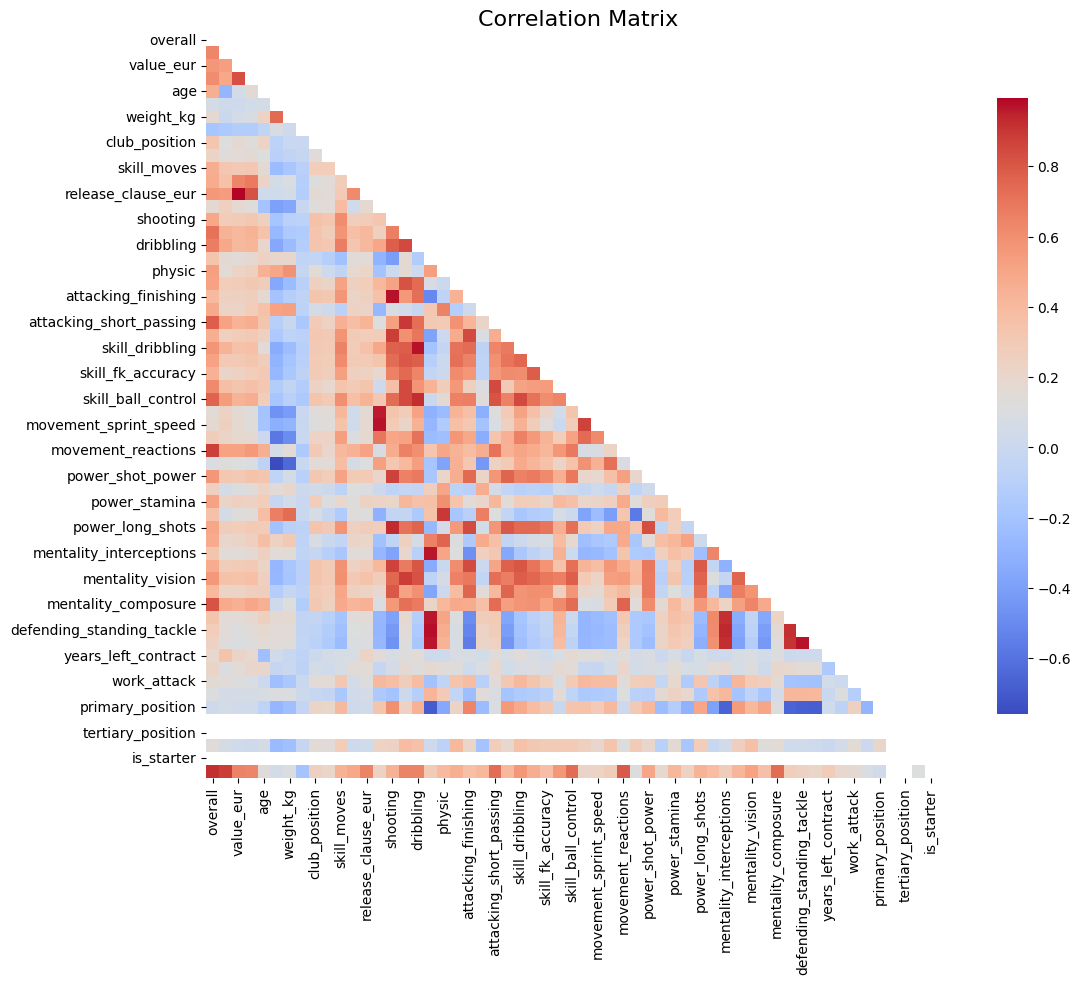

In [206]:
# correlation matrix to see most correlated features
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [207]:
# top 10 most correlated features with target
top_10_corr = corr["value_eur"].abs().sort_values(ascending=False)[1:11]
print("Top 10 most correlated features with target:")
print(top_10_corr)

Top 10 most correlated features with target:
release_clause_eur          0.995183
wage_eur                    0.824406
overall_potential           0.649487
international_reputation    0.639315
overall                     0.570239
potential                   0.533807
movement_reactions          0.517298
mentality_composure         0.452939
skill_ball_control          0.440499
attacking_short_passing     0.437511
Name: value_eur, dtype: float64


In [211]:
# baseline model with top 10 features
model = LinearRegression()
X = df[top_10_corr.index]
y = df["value_eur"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

RMSE: 1610040.82
R2: 0.95


In [ ]:
# Split first
X = df.drop(columns=["value_eur"], errors='ignore')
y = df["value_eur"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Merge temporarily for groupby operations
train_df = X_train.copy()
train_df["value_eur"] = y_train

# Compute mappings from training set only
club_map = train_df.groupby('club_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
league_map = train_df.groupby('league_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
work_rate_map = train_df.groupby('work_rate', observed=True)['value_eur'].median().sort_values().rank().to_dict()

# Apply mappings
X_train["club_name"] = X_train["club_name"].map(club_map)
X_test["club_name"] = X_test["club_name"].map(club_map)

X_train["league_name"] = X_train["league_name"].map(league_map)
X_test["league_name"] = X_test["league_name"].map(league_map)

X_train["work_rate"] = X_train["work_rate"].map(work_rate_map)
X_test["work_rate"] = X_test["work_rate"].map(work_rate_map)

In [ ]:
# List of columns to keep
cols_to_keep = [
    "release_clause_eur", "overall_potential", 
    "wage_eur", "age", "league_name", 
    "club_name", "work_rate", "is_starter",
    "secondary_position", "tertiary_position",
]

# Filter the DataFrame to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [ ]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    random_state=42,
)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {r2_score(y_train, train_preds)}")
print(f"Test R^2: {r2_score(y_test, test_preds)}")

Train RMSE: 297414.99340681836
Test RMSE: 558652.1658887943
Train R^2: 0.9984807926229545
Test R^2: 0.9943935966162789


In [ ]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 50, 100],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 6, 10], 
    'max_features': ['sqrt', 0.3, 0.5, 0.8]
}
search = RandomizedSearchCV(model, param_grid, n_iter=30 ,cv=5, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END max_depth=30, max_features=0.3, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=-1907118.982 total time=   1.8s
[CV 2/5] END max_depth=30, max_features=0.3, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=-2425917.374 total time=   1.7s
[CV 3/5] END max_depth=30, max_features=0.3, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=-795645.555 total time=   1.8s
[CV 4/5] END max_depth=30, max_features=0.3, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=-1076125.202 total time=   1.1s
[CV 5/5] END max_depth=30, max_features=0.3, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=-1231114.711 total time=   1.1s
[CV 3/5] END max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-715427.671 total time=   3.9s
[CV 1/5] END max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_

In [ ]:
model2 = RandomForestRegressor(
    n_estimators=200,
    max_depth=100,
    random_state=42
)

model2.fit(X_train, y_train)
train_preds = model2.predict(X_train)
test_preds = model2.predict(X_test)
# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {r2_score(y_train, train_preds)}")
print(f"Test R^2: {r2_score(y_test, test_preds)}")

Train RMSE: 278381.82945714536
Test RMSE: 556714.232157933
Train R^2: 0.9986690151484207
Test R^2: 0.9944324257630158


# MODEL WITH GOALKEEPERS

In [213]:
df = pd.read_csv("train.csv")
df = df[df["player_positions"].str.contains("GK", na=False)]
df.dropna(subset=["value_eur"], inplace=True)

In [214]:
df["overall_potential"] = df["overall"] * df["potential"]

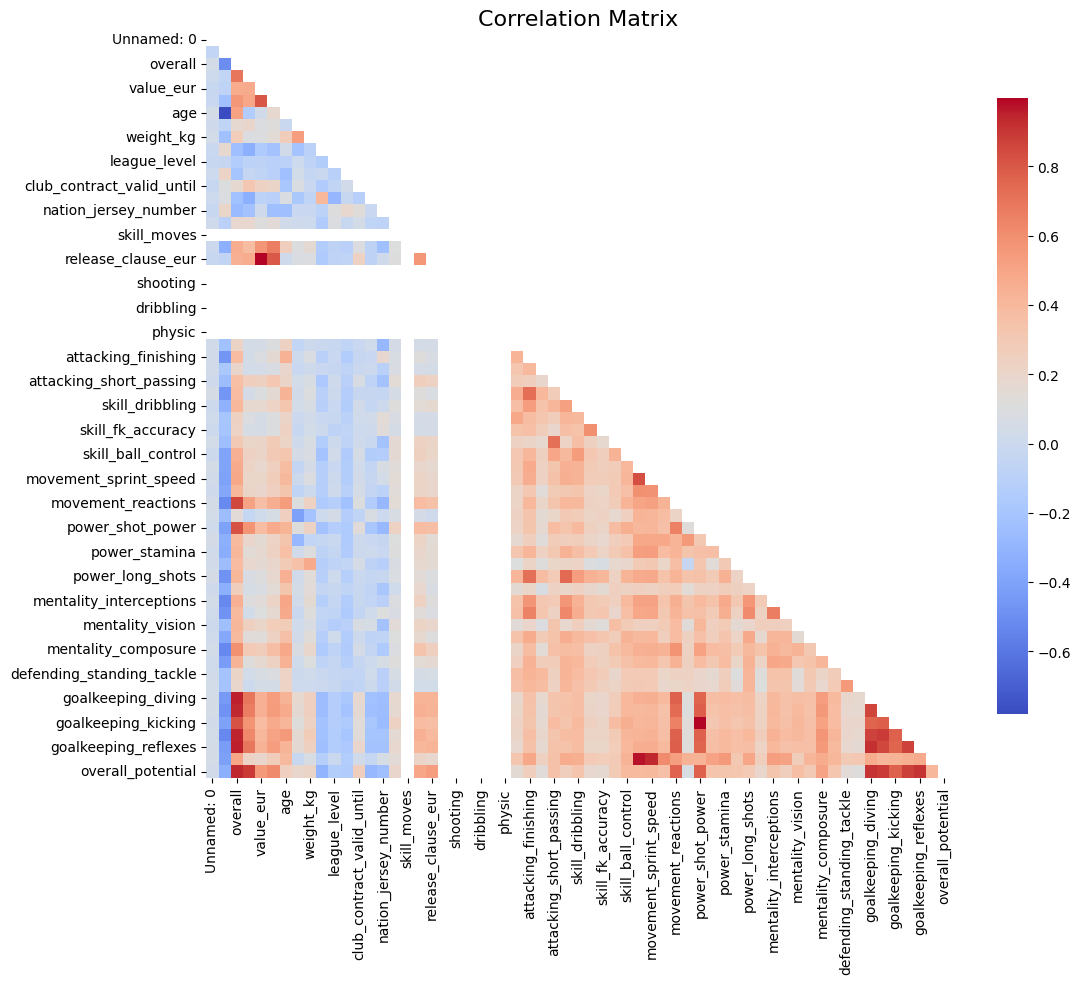

In [215]:
# correlation matrix to see most correlated features
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [216]:
# top 10 most correlated features with target
top_10_corr = corr["value_eur"].abs().sort_values(ascending=False)[1:11]
print("Top 10 most correlated features with target:")
print(top_10_corr)

Top 10 most correlated features with target:
release_clause_eur          0.997330
wage_eur                    0.809991
international_reputation    0.570904
overall_potential           0.550568
potential                   0.476593
overall                     0.465175
goalkeeping_handling        0.449480
goalkeeping_diving          0.447461
goalkeeping_reflexes        0.442109
goalkeeping_positioning     0.412582
Name: value_eur, dtype: float64


In [218]:
# baseline model using the top 10 features as input
model = LinearRegression()
X = df[top_10_corr.index]
y = df["value_eur"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

RMSE: 1336704.14
R2: 0.96


In [ ]:
X = df.drop(columns=["value_eur"], errors='ignore')
y = df["value_eur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Merge temporarily for groupby operations
train_df = X_train.copy()
train_df["value_eur"] = y_train

# Compute mappings from training set only
club_map = train_df.groupby('club_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
league_map = train_df.groupby('league_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
work_rate_map = train_df.groupby('work_rate', observed=True)['value_eur'].median().sort_values().rank().to_dict()

# Apply mappings
X_train["club_name"] = X_train["club_name"].map(club_map)
X_test["club_name"] = X_test["club_name"].map(club_map)

X_train["league_name"] = X_train["league_name"].map(league_map)
X_test["league_name"] = X_test["league_name"].map(league_map)

X_train["work_rate"] = X_train["work_rate"].map(work_rate_map)
X_test["work_rate"] = X_test["work_rate"].map(work_rate_map)

In [ ]:
# List of columns to keep based on the top correlations with 'value_eur'
cols_to_keep = [
    "release_clause_eur", "wage_eur", 
    "international_reputation", "overall_potential", 
    "goalkeeping_handling", "goalkeeping_diving", 
    "goalkeeping_reflexes", "goalkeeping_positioning", 
    "goalkeeping_kicking"
]

# Filter the DataFrame to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [ ]:
rf_gk = RandomForestRegressor(
    n_estimators=400,
    max_depth=50,
    random_state=42,
)

rf_gk.fit(X_train, y_train)
train_preds = rf_gk.predict(X_train)
test_preds = rf_gk.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {r2_score(y_train, train_preds)}")
print(f"Test R^2: {r2_score(y_test, test_preds)}")

Train RMSE: 760557.3338021102
Test RMSE: 531822.9997200699
Train R^2: 0.988112492918213
Test R^2: 0.9933713425594822


- need to add baseline model -> linear regression with top 10 most correlated features (so need correlation matrix for it)

# FINAL MODEL

In [244]:
# load data + extraction of first preferred position
data = pd.read_csv('train.csv')
data['position_first'] = data['player_positions'].str.split(',').str[0]
data = data.dropna(subset=['value_eur'])

In [245]:
# Train/test split
X = data[['overall', 'potential', 'age', 'position_first']]
y = np.log1p(data['value_eur'])  # Use log transform to reduce skew
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [246]:
# target encoding, considering only the training set
train_data = X_train.copy()
train_data['value_eur'] = np.expm1(y_train) 

position_means = train_data.groupby('position_first')['value_eur'].mean()
global_mean = train_data['value_eur'].mean()  # Fallback mean

X_train['position_target_enc'] = X_train['position_first'].map(position_means)
X_test['position_target_enc'] = X_test['position_first'].map(position_means).fillna(global_mean)

# Drop original position column
X_train = X_train.drop(columns='position_first')
X_test = X_test.drop(columns='position_first')


In [247]:
# XGBoost with default parameters 
xgb_baseline = xgb.XGBRegressor(random_state=42)
xgb_baseline.fit(X_train, y_train)
y_pred_baseline = np.expm1(xgb_baseline.predict(X_test))  # Inverse log1p
true_values_baseline = np.expm1(y_test)
rmse_baseline = np.sqrt(mean_squared_error(true_values_baseline, y_pred_baseline))
print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 396385.56


In [248]:
# Hyperparameter tuning
params = {
    'n_estimators': [2500],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(
    xgb_model, params,
    scoring='neg_root_mean_squared_error',
    cv=5, verbose=1, n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = np.expm1(best_model.predict(X_test))  # Inverse log1p
true_values = np.expm1(y_test)
# y_pred = np.where(
#     y_pred < 1_000_000,
#     np.round(y_pred / 25_000) * 25_000,
#     np.where(
#         y_pred < 10_000_000,
#         np.round(y_pred / 100_000) * 100_000,
#         np.round(y_pred / 500_000) * 500_000
#     )
# )
rmse = np.sqrt(mean_squared_error(true_values, y_pred))
print(f"Best RMSE (GridSearch): {rmse:.2f}")
print(f"Best parameters: {grid.best_params_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best RMSE (GridSearch): 211872.33
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 2500, 'subsample': 0.9}


In [238]:
# Hyperparameter tuning with early stopping 

# do again train/test split because now we need add also a validation set 
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# target encoding 
train_data = X_train.copy()
train_data['value_eur'] = np.expm1(y_train)
position_means = train_data.groupby('position_first')['value_eur'].mean()
global_mean = train_data['value_eur'].mean()  # Fallback mean
X_train['position_target_enc'] = X_train['position_first'].map(position_means)
X_val['position_target_enc'] = X_val['position_first'].map(position_means).fillna(global_mean)
X_test['position_target_enc'] = X_test['position_first'].map(position_means).fillna(global_mean)
X_train = X_train.drop(columns='position_first')
X_val = X_val.drop(columns='position_first')
X_test = X_test.drop(columns='position_first')

In [239]:
# Convert to DMatrix (XGBoost's internal format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.9,
    'colsample_bytree': 1.0,
    'seed': 42
}

# Train with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2500,
    evals=[(dval, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=True
)

# Predict and inverse transform
y_pred = np.expm1(model.predict(dtest))
true_values = np.expm1(y_test)

# Optional rounding
# y_pred = np.where(
#     y_pred < 1_000_000,
#     np.round(y_pred / 25_000) * 25_000,
#     np.where(
#         y_pred < 10_000_000,
#         np.round(y_pred / 100_000) * 100_000,
#         np.round(y_pred / 500_000) * 500_000
#     )
# )

rmse = np.sqrt(mean_squared_error(true_values, y_pred))
print(f"RMSE with Early Stopping (native API): {rmse:.2f}")

[0]	eval-rmse:1.10073
[1]	eval-rmse:0.99832
[2]	eval-rmse:0.90549
[3]	eval-rmse:0.82179
[4]	eval-rmse:0.74616
[5]	eval-rmse:0.67753
[6]	eval-rmse:0.61473
[7]	eval-rmse:0.55917
[8]	eval-rmse:0.50874
[9]	eval-rmse:0.46335
[10]	eval-rmse:0.42271
[11]	eval-rmse:0.38649
[12]	eval-rmse:0.35309
[13]	eval-rmse:0.32269
[14]	eval-rmse:0.29528
[15]	eval-rmse:0.27046
[16]	eval-rmse:0.24846
[17]	eval-rmse:0.22899
[18]	eval-rmse:0.21097
[19]	eval-rmse:0.19482
[20]	eval-rmse:0.18042
[21]	eval-rmse:0.16731
[22]	eval-rmse:0.15551
[23]	eval-rmse:0.14487
[24]	eval-rmse:0.13545
[25]	eval-rmse:0.12696
[26]	eval-rmse:0.11940
[27]	eval-rmse:0.11261
[28]	eval-rmse:0.10658
[29]	eval-rmse:0.10115
[30]	eval-rmse:0.09649
[31]	eval-rmse:0.09238
[32]	eval-rmse:0.08865
[33]	eval-rmse:0.08564
[34]	eval-rmse:0.08251
[35]	eval-rmse:0.07989
[36]	eval-rmse:0.07771
[37]	eval-rmse:0.07542
[38]	eval-rmse:0.07362
[39]	eval-rmse:0.07198
[40]	eval-rmse:0.07039
[41]	eval-rmse:0.06922
[42]	eval-rmse:0.06780
[43]	eval-rmse:0.0661

MAKE PREDICTIONS FOR THE TEST SET 

In [253]:
test = pd.read_csv("test.csv")

In [ ]:
# position first encoding -> remember to run the cell for the first XGBoost model, otherwise encoding not same 
test = test[['overall', 'potential', 'age', "player_positions"]]
test["position_first"] = test["player_positions"].str.split(",").str[0]
test = test.drop(columns=["player_positions"], errors='ignore')
test['position_target_enc'] = test['position_first'].map(position_means).fillna(global_mean)
test = test.drop(columns='position_first')

In [255]:
# make the predictions 
test_predictions = np.expm1(best_model.predict(test)) 

In [258]:
# create the submission file 
submission = pd.DataFrame({
    'value_eur': test_predictions
})
submission.to_csv('submission.csv', index=True)
print("Submission file created.")

Submission file created.
